Import Data

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import math

#import data from File function
def import_data(file_path):
    data_target = []
    data_input = []
    with open(file_path, 'r') as f:
        while True:
            # Splitting our dataset per colums based on the space separator
            data_str = f.readline().split(' ')
            if not data_str[0]:
                break
            # Target is the first column
            data_target.append(float(data_str[0]))
            # Features are columns 2 to 48, where we take only the values
            data_input.append([float(a.split(':')[1]) for a in data_str[2:48]])

    x = np.array(data_input)
    y = np.array(data_target).reshape((-1, 1))
    return x, y

file_path = r'Querylevelnorm.txt'
# import data from Querylevelnorm.txt
x, y = import_data(file_path)
print("X shape is", x.shape, "\nY shape is", y.shape)

xT = np.transpose(x)
# Remove features with variance zero as they have no impact on the model
p = []
for i in range(0,46):
    if np.var(xT[i]) == float(0):
        p.append(i)
print(p)
x = np.delete(x, p, axis = 1)


xT = np.transpose(x)
a = 0
b = 0
c = 0
# calculating the data variation
for i in range(0,69623):
    if y[i] == 0:
        a += 1
    elif y[i] == 1:
        b += 1
    else:
        c += 1

print('no of 0 target value value:' + str(a))
print('no of 1 target value value:' + str(b))
print('no of 2 target value value:' + str(c))
print("X shape is", x.shape, "\nxT shape is", xT.shape)  

X shape is (69623, 46) 
Y shape is (69623, 1)
[5, 6, 7, 8, 9]
no of 0 target value value:51632
no of 1 target value value:14128
no of 2 target value value:3863
X shape is (69623, 41) 
xT shape is (41, 69623)


Data Split using sklearn

In [16]:
from sklearn.cross_validation import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.111, random_state=1)

print("X train shape is", x_train.shape, "\nY shape train is", y_train.shape)
print("X test shape is", x_test.shape, "\nY shape test is", y_test.shape)
print("X validation shape is", x_val.shape, "\nY shape validation is", y_val.shape)

X train shape is (55704, 41) 
Y shape train is (55704, 1)
X test shape is (6963, 41) 
Y shape test is (6963, 1)
X validation shape is (6956, 41) 
Y shape validation is (6956, 1)




Lets Do Closed Form Solution

1. Create Phi for t = W * Phi

Calculate Mu and Big Sigma for Phi

In [17]:
# Finding Mu using kmeans cluster

from sklearn.cluster import KMeans

def KmeansCluster(n_clusters):
    kmeans = KMeans(n_clusters)
    # Fitting
    kmeans = kmeans.fit(x_train)
    # Centroid values
    centroids = kmeans.cluster_centers_
    return centroids


In [18]:
# calculate BigSigma- Its only dependent on training data
#-------------------------------------------------------
BigSigma = np.zeros((x_train.shape[1],x_train.shape[1]))
varVect  = []
x_trainT = np.transpose(x_train)

for i in range(0,x_train.shape[1]):
    vct = []
    for j in range(0,len(x_train)):
        vct.append(x_trainT[i][j])    
    varVect.append(np.var(vct))

for i in range(x_train.shape[1]):
        BigSigma[i][i] = varVect[i]
        
BigSigma = np.dot(200,BigSigma)
#-------------------------------------------------------
print("BigSigma shape is", BigSigma.shape)

BigSigma shape is (41, 41)


In [19]:
# now calculate Phi

#used from code given
def GetScalar(DataRow,MuRow, BigSigInv):  # To calculate the exponential term in basis function.
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

def CalculatePhi(Data, Mu, BigSigma): # determine phi matrix value
    DataT = np.transpose(Data)
    Phi = np.zeros((int(DataT.shape[1]),len(Mu))) 
    BigSigInv = np.linalg.inv(BigSigma)
    
    for i in range(0,len(Mu)):
        for j in range(0,int(DataT.shape[1])):
            Phi[j][i] = math.exp(-0.5 * GetScalar(Data[j],Mu[i],BigSigInv))
    return Phi

def CalculateWeightsClosedForm(Phi_train, y_train, Lambda): # Calculates Weights in Closed Form Solution
    Phi_trainT = np.transpose(Phi_train) 
    Lambda_I = np.identity(len(Phi_train[0]))
    for i in range(0,len(Phi_train[0])):
        Lambda_I[i][i] = Lambda
    
    # phisquare = phitranspose * phi
    PHI_SQR     = np.dot(Phi_trainT,Phi_train)
    # add the regulirization term
    PHI_SQR_RE  = np.add(Lambda_I,PHI_SQR)
    # inverse of phisquare regulizer
    PHI_SQR_INV = np.linalg.inv(PHI_SQR)
    # phitranspose * t
    W_rest = np.dot(Phi_trainT, y_train)
    W = np.dot(PHI_SQR_INV,W_rest)
    return W


In [20]:
# return target value used for validation and testing
def GetValTest(Phi,W):
    Y = np.dot(Phi, W)
    return Y

# returns accuracy and root mean square of the dataset given
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2) # square of actual - predicted value
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]): # check no of correctly predicted values
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT))) #accuracy = no of correctly predicted / total predicted
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT)))) # return accuracy and erms

In [21]:
n_clusters = 10
Lambda = 0.3

centroids = KmeansCluster(n_clusters)
print(centroids.shape)

Phi_train = CalculatePhi(x_train, centroids, BigSigma)
W = CalculateWeightsClosedForm(Phi_train, y_train, Lambda)
print(Phi_train.shape)
print(W.shape) 

Phi_Test = CalculatePhi(x_test, centroids, BigSigma) 
Phi_Val  = CalculatePhi(x_val, centroids, BigSigma)

TR_TEST_OUT  = GetValTest(Phi_train, W)
VAL_TEST_OUT = GetValTest(Phi_Val, W)
TEST_OUT     = GetValTest(Phi_Test, W)

TrainingAccuracy   = str(GetErms(TR_TEST_OUT, y_train))
ValidationAccuracy = str(GetErms(VAL_TEST_OUT, y_val))
TestAccuracy       = str(GetErms(TEST_OUT, y_test))

(10, 41)
(55704, 10)
(10, 1)


In [8]:
print ('UBITname      = abhavlut')
print ('Person Number = 50288904')
print ('----------------------------------------------------')
print ("------------------LeToR Data------------------------")
print ('----------------------------------------------------')
print ("-------Closed Form with Radial Basis Function-------")
print ('----------------------------------------------------')

print ("E_rms Training   = " + TrainingAccuracy.split(',')[1])
print ("E_rms Validation = " + ValidationAccuracy.split(',')[1])
print ("E_rms Testing    = " + TestAccuracy.split(',')[1])
print ("Accuracy Training   = " + TrainingAccuracy.split(',')[0])
print ("Accuracy Validation = " + ValidationAccuracy.split(',')[0])
print ("Accuracy Testing    = " + TestAccuracy.split(',')[0])

UBITname      = abhavlut
Person Number = 50288904
----------------------------------------------------
------------------LeToR Data------------------------
----------------------------------------------------
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
E_rms Training   = 0.5560733243603909
E_rms Validation = 0.5593468916031554
E_rms Testing    = 0.5552526028411682
Accuracy Training   = 73.1922303604768
Accuracy Validation = 73.23174238067855
Accuracy Testing    = 73.54588539422663


In [173]:
# varying Cluster Size
n_clusters = [5,10,15,20,25,30,40,50,75,100]
Lambda = 0.3
TrainingERMS = []
ValidationERMS = [] 
TestERMS = []
TrainingAccuracy = [] 
ValidationAccuracy = [] 
TestAccuracy =[]    

for i in range(0,10):
    centroids = KmeansCluster(n_clusters[i])
    print(centroids.shape)

    Phi_train = CalculatePhi(x_train, centroids, BigSigma)
    W = CalculateWeightsClosedForm(Phi_train, y_train, Lambda)
    
    Phi_Test = CalculatePhi(x_test, centroids, BigSigma) 
    Phi_Val  = CalculatePhi(x_val, centroids, BigSigma)

    TR_TEST_OUT  = GetValTest(Phi_train, W)
    VAL_TEST_OUT = GetValTest(Phi_Val, W)
    TEST_OUT     = GetValTest(Phi_Test, W)

    TrainingERMS.append(float(GetErms(TR_TEST_OUT, y_train).split(',')[1]))
    ValidationERMS.append(float(GetErms(VAL_TEST_OUT, y_val).split(',')[1]))
    TestERMS.append(float(GetErms(TEST_OUT, y_test).split(',')[1]))
    TrainingAccuracy.append(float(GetErms(TR_TEST_OUT, y_train).split(',')[0]))
    ValidationAccuracy.append(float(GetErms(VAL_TEST_OUT, y_val).split(',')[0]))
    TestAccuracy.append(float(GetErms(TEST_OUT, y_test).split(',')[0]))

(5, 41)
(10, 41)
(15, 41)
(20, 41)
(25, 41)
(30, 41)
(40, 41)
(50, 41)
(75, 41)
(100, 41)


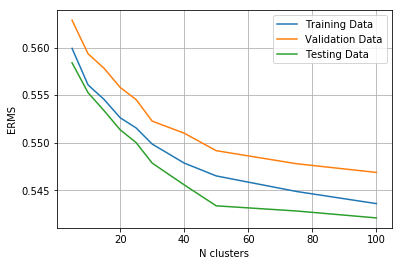

In [174]:
fig, ax = plt.subplots()
line1, = ax.plot(n_clusters, TrainingERMS, label='Training Data')
line2, = ax.plot(n_clusters, ValidationERMS, label='Validation Data')
line3, = ax.plot(n_clusters, TestERMS, label='Testing Data')
ax.set_xlabel('N clusters')
ax.set_ylabel('ERMS')
ax.grid(True)
ax.legend()
plt.show()

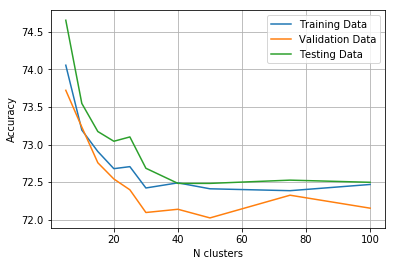

In [175]:
fig, ax = plt.subplots()
line1, = ax.plot(n_clusters, TrainingAccuracy, label='Training Data')
line2, = ax.plot(n_clusters, ValidationAccuracy, label='Validation Data')
line3, = ax.plot(n_clusters, TestAccuracy, label='Testing Data')
ax.set_xlabel('N clusters')
ax.set_ylabel('Accuracy')
ax.grid(True)
ax.legend()
plt.show()

In [169]:
# varying Lamda Size
n_clusters = 10
Lambda = [0.1,0.2,0.3,0.4,0.5,1,2,10,100]
TrainingERMS = []
ValidationERMS = [] 
TestERMS = []
TrainingAccuracy = [] 
ValidationAccuracy = [] 
TestAccuracy =[]    

centroids = KmeansCluster(n_clusters)
print(centroids.shape)
Phi_train = CalculatePhi(x_train, centroids, BigSigma)

for i in range(0,9):
    W = CalculateWeightsClosedForm(Phi_train, y_train, Lambda[i])

    Phi_Test = CalculatePhi(x_test, centroids, BigSigma) 
    Phi_Val  = CalculatePhi(x_val, centroids, BigSigma)

    TR_TEST_OUT  = GetValTest(Phi_train, W)
    VAL_TEST_OUT = GetValTest(Phi_Val, W)
    TEST_OUT     = GetValTest(Phi_Test, W)

    TrainingERMS.append(float(GetErms(TR_TEST_OUT, y_train).split(',')[1]))
    ValidationERMS.append(float(GetErms(VAL_TEST_OUT, y_val).split(',')[1]))
    TestERMS.append(float(GetErms(TEST_OUT, y_test).split(',')[1]))
    TrainingAccuracy.append(float(GetErms(TR_TEST_OUT, y_train).split(',')[0]))
    ValidationAccuracy.append(float(GetErms(VAL_TEST_OUT, y_val).split(',')[0]))
    TestAccuracy.append(float(GetErms(TEST_OUT, y_test).split(',')[0]))

(10, 41)


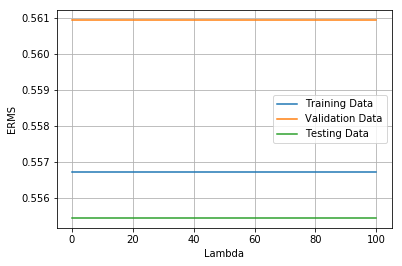

In [170]:
fig, ax = plt.subplots()
line1, = ax.plot(Lambda, TrainingERMS, label='Training Data')
line2, = ax.plot(Lambda, ValidationERMS, label='Validation Data')
line3, = ax.plot(Lambda, TestERMS, label='Testing Data')
ax.set_xlabel('Lambda')
ax.set_ylabel('ERMS')
ax.grid(True)
ax.legend()
plt.show()

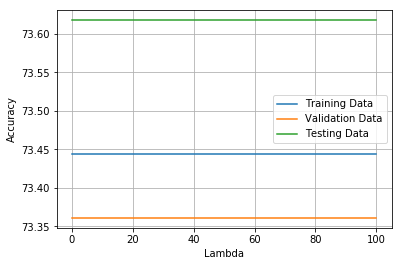

In [172]:
fig, ax = plt.subplots()
line1, = ax.plot(Lambda, TrainingAccuracy, label='Training Data')
line2, = ax.plot(Lambda, ValidationAccuracy, label='Validation Data')
line3, = ax.plot(Lambda, TestAccuracy, label='Testing Data')
ax.set_xlabel('Lambda')
ax.set_ylabel('Accuracy')
ax.grid(True)
ax.legend()
plt.show()

2. Gradient Descent Solution

In [39]:
# initialize weights randomly
W_Now = np.random.rand(10,) 
#print(W_Now.shape)
La           = 2
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
L_Acc_Val   = []
L_Acc_TR    = []
L_Acc_Test  = []
W_Mat        = []


print(y_train.shape)
print(Phi_train.shape)
y_train = np.reshape(y_train, (55704,))  
print(y_train.shape)

ErmsVal   = []
ErmsTR    = []
ErmsTest  = []
AccVal   = []
AccTR    = []
AccTest  = []


learningRate = [0.001,0.01, 0.05,0.1,0.15,0.2,0.3]
for j in range(0,7):
    L_Erms_Val   = []
    L_Erms_TR    = []
    L_Erms_Test  = []
    L_Acc_Val   = []
    L_Acc_TR    = []
    L_Acc_Test  = []
    for i in range(0,400):

        #print ('---------Iteration: ' + str(i) + '--------------')
        Delta_E_D     = -np.dot((y_train[i] - np.dot(np.transpose(W_Now),Phi_train[i])),Phi_train[i]) # weights updated
        La_Delta_E_W  = np.dot(La,W_Now) # SCALING
        Delta_E       = np.add(Delta_E_D,La_Delta_E_W)   
        Delta_W       = -np.dot(learningRate[j],Delta_E) # learning quotient
        W_T_Next      = W_Now + Delta_W # after single iteration - updated weight
        W_Now         = W_T_Next

        #-----------------TrainingData Accuracy---------------------#
        TR_TEST_OUT   = GetValTest(Phi_train,W_T_Next) # predicted t for training data
        Erms_TR       = GetErms(TR_TEST_OUT,y_train)
        L_Erms_TR.append(float(Erms_TR.split(',')[1])) #erms
        L_Acc_TR.append(float(Erms_TR.split(',')[0]))  #Accuracy

        #-----------------ValidationData Accuracy---------------------#
        VAL_TEST_OUT  = GetValTest(Phi_Val,W_T_Next) # predicted t for Validation data
        Erms_Val      = GetErms(VAL_TEST_OUT,y_val)
        L_Erms_Val.append(float(Erms_Val.split(',')[1])) #erms
        L_Acc_Val.append(float(Erms_Val.split(',')[0]))  #Accuracy

        #-----------------TestingData Accuracy---------------------#
        TEST_OUT      = GetValTest(Phi_Test,W_T_Next) # predicted t for Testing data
        Erms_Test = GetErms(TEST_OUT,y_test)
        L_Erms_Test.append(float(Erms_Test.split(',')[1])) #erms
        L_Acc_Test.append(float(Erms_Test.split(',')[0]))  #Accuracy
    
    ErmsTR.append(np.around(min(L_Erms_TR),5))
    AccTR.append(np.around(max(L_Acc_TR),5))
    ErmsVal.append(np.around(min(L_Erms_Val),5))
    AccVal.append(np.around(max(L_Acc_Val),5))
    ErmsTest.append(np.around(min(L_Erms_Test),5))
    AccTest.append(np.around(max(L_Acc_Test),5))
    print('loop complete')

(55704,)
(55704, 10)
(55704,)
loop complete
loop complete
loop complete


KeyboardInterrupt: 

In [121]:
print ('----------Gradient Descent Solution--------------------')
for i in range(0,7):
    print ("\nLearning Rate : " + str(learningRate[i]))
    print ("\nE_rms Training for loop " + str(i) +": " + str(ErmsTR[i]))
    print ("\nE_rms Validation for loop " + str(i) +": " + str(ErmsVal[i]))
    print ("\nE_rms Testing for loop " + str(i) +": " + str(ErmsTest[i]))

    print ("\nAcc Training for loop " + str(i) +": " + str(AccTR[i]))
    print ("\nAcc Validation for loop " + str(i) +": " + str(AccVal[i]))
    print ("\nAcc Testing for loop " + str(i) +": " + str(AccTest[i]))

----------Gradient Descent Solution--------------------
Learning Rate : 0.001

E_rms Training for loop 0: 0.57091

E_rms Validation for loop 0: 0.57383

E_rms Testing for loop 0: 0.56849

Acc Training for loop 0: 74.14548

Acc Validation for loop 0: 73.83554

Acc Testing for loop 0: 74.59428
Learning Rate : 0.01

E_rms Training for loop 1: 0.57137

E_rms Validation for loop 1: 0.57427

E_rms Testing for loop 1: 0.56877

Acc Training for loop 1: 74.14548

Acc Validation for loop 1: 73.83554

Acc Testing for loop 1: 74.59428
Learning Rate : 0.05

E_rms Training for loop 2: 0.5717

E_rms Validation for loop 2: 0.5745

E_rms Testing for loop 2: 0.56912

Acc Training for loop 2: 74.14548

Acc Validation for loop 2: 73.84991

Acc Testing for loop 2: 74.59428
Learning Rate : 0.1

E_rms Training for loop 3: 0.57487

E_rms Validation for loop 3: 0.57814

E_rms Testing for loop 3: 0.57183

Acc Training for loop 3: 74.14548

Acc Validation for loop 3: 73.83554

Acc Testing for loop 3: 74.59428
Le

In [133]:
ErmsTRPlot = ErmsTR.pop()
ErmsValPlot = ErmsVal.pop()
ErmsTestPlot = ErmsTest.pop()

AccTRPlot = AccTR.pop()
AccValPlot = AccVal.pop()
AccTestPlot = AccTest.pop()
learningRate.pop()
print(ErmsTRPlot)

3.60625


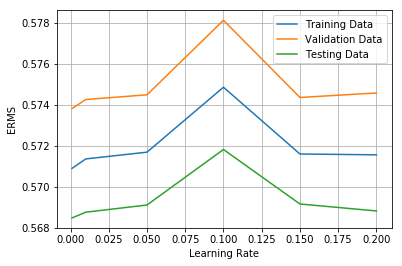

In [145]:
fig, ax = plt.subplots()
line1, = ax.plot(learningRate, ErmsTR, label='Training Data')
line2, = ax.plot(learningRate, ErmsVal, label='Validation Data')
line3, = ax.plot(learningRate, ErmsTest, label='Testing Data')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('ERMS')
ax.grid(True)
ax.legend()
plt.show()

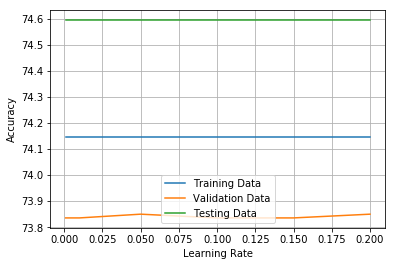

In [143]:
fig, ax = plt.subplots()
line1, = ax.plot(learningRate, AccTR, label='Training Data')
line2, = ax.plot(learningRate, AccVal, label='Validation Data')
line3, = ax.plot(learningRate, AccTest, label='Testing Data')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Accuracy')
ax.grid(True)
ax.legend()
plt.show()